In [2]:
# subsampled plots, run this overnight or something.

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird. sike using jax
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr
import jax.numpy as jnp

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number, prevent aliasing
wf_npixels = 1024

# smaller psf, only 10 sources. more than 18ish breaks on my macbook
psf_npixels = 128

# no need for oversampling
oversample = 1 # can change, put to 1 for normal toliman

# toliman pixel scale (arc seconds)
psf_pixel_scale = 0.375

# just for future use:
det_pixelsize = dlu.arcsec2rad(psf_pixel_scale/oversample)

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

# importing optax stuff
# Optimisation
import zodiax as zdx
import optax

from tqdm.notebook import tqdm


In [3]:
# modelling johson noise
# NOte: OVERSAMPLE SHOULD BE 1... unless.... we want 200% better pixel scale!!!
# modify for downsample
def bg_noise(dark_current, key): 
    noise_vals = (jnp.pi/2)**0.5*dark_current*jnp.abs(jr.normal(key, (int(psf_npixels*oversample),int(psf_npixels*oversample))))
    return noise_vals

# there is a 'addconstant' detector layer. but not sure how I can go from that to what I want.
# I think I just use it for modelling the mean value of detector noise.

In [4]:
r_rmse = jnp.zeros((4,4))
flux_rmse = jnp.zeros((4,4))
indices = jnp.array([1,2,3,5]) # these are the indices that dont give NaNs for some reason...
subsampling = jnp.array([2,4,8,16])
print(subsampling)
print(indices)
print(r_rmse)

[ 2  4  8 16]
[1 2 3 5]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [5]:
for s, subsample in enumerate(subsampling):
    for ind, idx in enumerate(indices):
        # gonna try 10 sources close(r) together... 50 takes way too long... prone to breaking on my silly macbook.
        n_sources = 10

        # good maximum for 512 by 512 grid
        max_pos = 20/oversample
        positions_arcsecs = jr.uniform(jr.PRNGKey(idx), (n_sources, 2), minval=-max_pos, maxval=max_pos)
        positions_rads = dlu.arcsec2rad(positions_arcsecs)

        # fluxes from half-normal distribution, standard deviation 50,000 photons
        fluxes = 50000*jnp.abs(jr.normal(jr.PRNGKey(idx), (n_sources,)))

        # only 1 wavelength
        wavelength = 585e-9 #mid(ish) point of toliman thing
        wavelengths = wavelength * jnp.linspace(1, 1, 1)

        sources = dl.PointSources(wavelengths,positions_rads,fluxes)

        # adding the constant to model dark current... not working too well!
        detector = dl.LayeredDetector([dl.layers.AddConstant(0),dl.layers.Downsample(subsample)])

        tolTelescope = dl.Telescope(tolPupilSystem, sources, detector)
        airyTelescope = dl.Telescope(airyApertureSystem, sources, detector)

        init_dark_current = 2 # just 2 the whole time here
        # no poisson
        # ENSURE THAT THE NOISE IS DOWNSAMPLED. Otherwise its too much and defeats the purpose (I THINK!) 
        # MEAN MUST BE FALSE!! OTHERWISE DATA IS TOO GOOD!!
        tolData = tolTelescope.model() + dlu.downsample(bg_noise(init_dark_current, jr.PRNGKey(idx)),subsample,mean=False)
        
        model_positions = 'source.position'
        model_fluxes = 'source.flux'

        # don't know about this one
        model_dark_current = 'detector.AddConstant.value'

        # params
        parameters = [model_positions, model_fluxes, model_dark_current]

        # just gonna do toliman for now
        # plus/mins 0.5 pixels in each dimension. gonna assume uniform distribution because nothing mentioned

        tolModel = tolTelescope.add(model_positions, jr.uniform(jr.PRNGKey(idx),(n_sources, 2),minval=-0.5*det_pixelsize,maxval=0.5*det_pixelsize))

        # fluxes +/- 10%
        tolModel = tolModel.multiply(model_fluxes, jr.uniform(jr.PRNGKey(idx), (n_sources,), minval=0.9, maxval=1.1))

        # dark current +/-20%
        tolModel = tolModel.add(model_dark_current, init_dark_current*jr.uniform(jr.PRNGKey(idx),1,minval=0.8,maxval=1.2))

        # this stuff really depends on how many sources you have
        pos_optimiser   = optax.adam(7e-9) # good value
        flux_optimiser  = optax.adam(200) # good value
        current_optimiser = optax.adam(0.02*0.2*init_dark_current)

        optimisers = [pos_optimiser, flux_optimiser, current_optimiser]

        optim, opt_state = zdx.get_optimiser(tolModel, parameters, optimisers)

        @zdx.filter_jit
        @zdx.filter_value_and_grad(parameters)
        def loss_fn(model, data):
            out = model.model()
            return jnp.sum((data-out)**2)

        losses, models_out = [], []
        min_iters = 100  # Ensure at least 100 iterations are completed before checking
        threshold = 0.01  # 1% change threshold

        losses, models_out = [], []
        with tqdm(range(1000),desc='Gradient Descent') as t:
            for i in t: 
                loss, grads = loss_fn(tolModel, tolData)    
                updates, opt_state = optim.update(grads, opt_state)
                tolModel = zdx.apply_updates(tolModel, updates)
                losses.append(loss)
                models_out.append(tolModel)
                # Compute log loss and update progress bar
                log_loss = jnp.log10(loss)
                t.set_description("Log Loss: {:.3f}".format(log_loss)) 
                if jnp.isnan(loss):
                    break
                # Check for early stopping after at least 100 iterations
                if i >= min_iters:
                    recent_losses = jnp.log10(jnp.array(losses[-100:]))  # Last 100 losses
                    initial_loss = jnp.log10(recent_losses[0])
                    final_loss = jnp.log10(recent_losses[-1])
                    
                    if jnp.abs(final_loss - initial_loss) / initial_loss < threshold:
                        print(f"Early stopping at iteration {i} as log loss change is below {threshold * 100}%.")
                        break

        nepochs = len(models_out)
        psfs_out = models_out[-1].model()

        positions_found  = jnp.array([model.get(model_positions) for model in models_out])
        fluxes_found     = jnp.array([model.get(model_fluxes)    for model in models_out])
        current_found = jnp.array([model.get(model_dark_current) for model in models_out])

        flux_residuals = fluxes - fluxes_found
        current_residuals = init_dark_current - current_found

        #scaler = 1e3
        positions_residuals = positions_rads - positions_found
        r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
        r_residuals = dlu.rad2arcsec(r_residuals_rads)
        flux_rmse = flux_rmse.at[s, ind].set(jnp.mean(flux_residuals[-1]**2)**0.5)
        r_rmse = r_rmse.at[s, ind].set(jnp.mean(r_residuals[-1]**2)**0.5)
        print(flux_rmse)
        print(r_rmse)


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 230 as log loss change is below 1.0%.
[[61.352917  0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]]
[[0.00625927 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 263 as log loss change is below 1.0%.
[[61.352917 49.01984   0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]]
[[0.00625927 0.00222201 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 297 as log loss change is below 1.0%.
[[61.352917 49.01984  58.63715   0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]]
[[0.00625927 0.00222201 0.00212246 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 288 as log loss change is below 1.0%.
[[61.352917 49.01984  58.63715  96.50452 ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 237 as log loss change is below 1.0%.
[[61.352917 49.01984  58.63715  96.50452 ]
 [54.501003  0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 252 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329    0.         0.      ]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 283 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924   0.      ]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 286 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 267 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456    0.         0.         0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 246 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555   0.         0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.         0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 295 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598    0.      ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.        ]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 287 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598  183.1165  ]
 [  0.         0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.03181442]
 [0.         0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 388 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598  183.1165  ]
 [568.58575    0.         0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.03181442]
 [0.08722774 0.         0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 288 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598  183.1165  ]
 [568.58575  302.32092    0.         0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.03181442]
 [0.08722774 0.03667581 0.         0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 412 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598  183.1165  ]
 [568.58575  302.32092  298.02823    0.      ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.03181442]
 [0.08722774 0.03667581 0.08144429 0.        ]]


Gradient Descent:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping at iteration 466 as log loss change is below 1.0%.
[[ 61.352917  49.01984   58.63715   96.50452 ]
 [ 54.501003 115.05329   59.498924 128.07574 ]
 [354.42456  115.407555 103.20598  183.1165  ]
 [568.58575  302.32092  298.02823  433.64966 ]]
[[0.00625927 0.00222201 0.00212246 0.00514687]
 [0.01453968 0.00603766 0.00544724 0.02234907]
 [0.03703849 0.01869594 0.01909075 0.03181442]
 [0.08722774 0.03667581 0.08144429 0.05901524]]


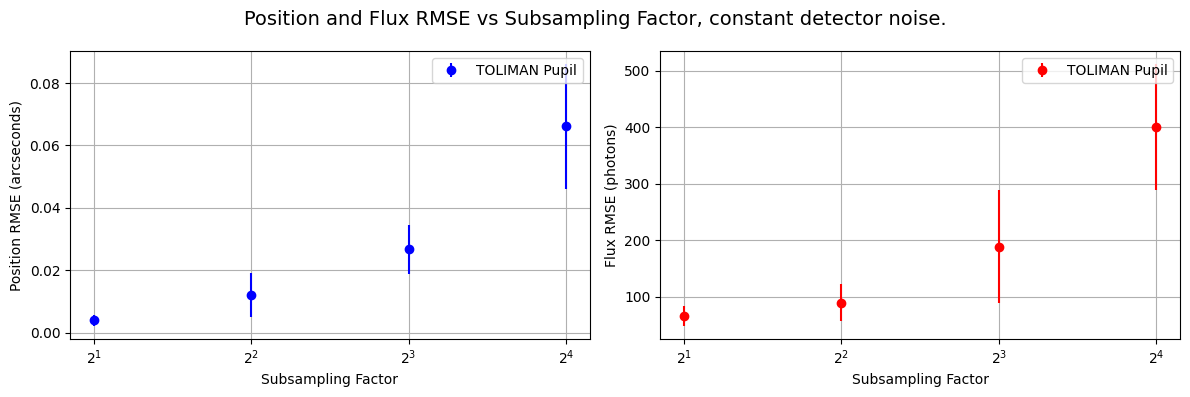

In [9]:
flux_means = jnp.nanmean(flux_rmse[:,:4],axis=1)
r_means = jnp.nanmean(r_rmse[:,:4],axis=1)
flux_sds = jnp.nanstd(flux_rmse[:,:4],axis=1)
r_sds = jnp.nanstd(r_rmse[:,:4],axis=1)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Position RMSE subplot
axes[0].errorbar(subsampling, r_means, yerr=r_sds, fmt='o', color='blue', label="TOLIMAN Pupil")
axes[0].set_xlabel('Subsampling Factor')
axes[0].set_xscale('log',base=2)
axes[0].set_ylabel('Position RMSE (arcseconds)')
axes[0].legend()
axes[0].grid(True)

# Flux RMSE subplot
axes[1].errorbar(subsampling, flux_means, yerr=flux_sds, fmt='o', color='red', label="TOLIMAN Pupil")
axes[1].set_xlabel('Subsampling Factor')
axes[1].set_xscale('log',base=2)
axes[1].set_ylabel('Flux RMSE (photons)')
axes[1].legend()
axes[1].grid(True)

# Add a big title
fig.suptitle('Position and Flux RMSE vs Subsampling Factor, constant detector noise.', fontsize=14)
plt.tight_layout()
